# Train Model Fraud Detection với XGBoost

Notebook này thực hiện:
1. Đọc dữ liệu đã xử lý từ HDFS (Parquet)
2. Chia train/test theo thời gian
3. Chuẩn hóa dữ liệu
4. Train model XGBoost
5. Đánh giá và tối ưu ngưỡng
6. Lưu model và scaler

## 1. Import thư viện và cấu hình Spark

In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import warnings
warnings.filterwarnings('ignore')

# Khởi tạo Spark Session
spark = SparkSession.builder \
    .appName("Fraud Detection Training") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

print("✅ Spark Session đã được khởi tạo")
print(f"Spark Version: {spark.version}")

✅ Spark Session đã được khởi tạo
Spark Version: 3.3.0


## 2. Đọc dữ liệu đã xử lý từ HDFS

In [2]:
# Đọc dữ liệu đã được xử lý từ HDFS
hdfs_input_path = "hdfs://namenode:9000/data/output/paysim_preprocessed.parquet"

df_spark = spark.read.parquet(hdfs_input_path)

print(f"✅ Đã đọc dữ liệu từ HDFS: {hdfs_input_path}")
print(f"Số dòng: {df_spark.count():,}")
print(f"Số cột: {len(df_spark.columns)}")

# Hiển thị schema
print("\nSchema:")
df_spark.printSchema()

# Hiển thị mẫu
print("\n📊 Mẫu dữ liệu:")
df_spark.show(5)

✅ Đã đọc dữ liệu từ HDFS: hdfs://namenode:9000/data/output/paysim_preprocessed.parquet
Số dòng: 2,493,276
Số cột: 14

Schema:
root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- type_encoded: integer (nullable = true)
 |-- amount: double (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- errorBalanceOrig: double (nullable = true)
 |-- errorBalanceDest: double (nullable = true)
 |-- amount_over_oldbalance: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- amount_log: double (nullable = true)


📊 Mẫu dữ liệu:
+----+--------+------------+---------+-------------+--------------+--------------+--------------+-------+-------------------+------------------+----------------------+----+------------------+
|step|    type|type_encoded|   amount|oldbalanceOrg|

## 3. Chuyển sang Pandas và chia train/test theo thời gian

In [3]:
# Chia train/test theo thời gian trên Spark (không cần chuyển sang Pandas)
print("📊 Chia dữ liệu train/test theo thời gian...")

# Tính quantile 70% của step
cut_step = df_spark.approxQuantile("step", [0.7], 0.01)[0]
print(f"Cut step: {cut_step}")

# Chia train/test
train_spark = df_spark.filter(col("step") <= cut_step)
test_spark = df_spark.filter(col("step") > cut_step)

print(f"\n✅ Train size: {train_spark.count():,}")
print(f"   Tỷ lệ fraud: {train_spark.select(avg('isFraud')).first()[0]:.6f}")
print(f"\n✅ Test size: {test_spark.count():,}")
print(f"   Tỷ lệ fraud: {test_spark.select(avg('isFraud')).first()[0]:.6f}")

📊 Chia dữ liệu train/test theo thời gian...
Cut step: 322.0

✅ Train size: 1,744,580
   Tỷ lệ fraud: 0.001879

✅ Test size: 748,696
   Tỷ lệ fraud: 0.005500


## 4. Chuẩn bị features với VectorAssembler

In [4]:
from pyspark.ml.feature import VectorAssembler, StandardScaler as SparkScaler

# Chọn features để train
feature_cols = ['type_encoded', 'amount_log', 'errorBalanceOrig', 'errorBalanceDest', 
                'amount_over_oldbalance', 'hour']

print(f"📋 Features sử dụng: {feature_cols}")

# Bước 1: Tạo vector từ features
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_raw"
)

# Bước 2: Chuẩn hóa features
scaler = SparkScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=True
)

# Apply assembler
train_assembled = assembler.transform(train_spark)
test_assembled = assembler.transform(test_spark)

# Fit scaler trên train và transform cả train và test
scaler_model = scaler.fit(train_assembled)
train_scaled = scaler_model.transform(train_assembled)
test_scaled = scaler_model.transform(test_assembled)

print("✅ Đã tạo features vector và chuẩn hóa")
print(f"   Train samples: {train_scaled.count():,}")
print(f"   Test samples: {test_scaled.count():,}")

📋 Features sử dụng: ['type_encoded', 'amount_log', 'errorBalanceOrig', 'errorBalanceDest', 'amount_over_oldbalance', 'hour']
✅ Đã tạo features vector và chuẩn hóa
   Train samples: 1,744,580
   Test samples: 748,696


In [5]:
# Lưu scaler model để dùng khi inference
scaler_model.write().overwrite().save("spark_scaler_model")
print("✅ Đã lưu Spark scaler model: spark_scaler_model/")

✅ Đã lưu Spark scaler model: spark_scaler_model/


## 5. Train model với GBTClassifier (Spark MLlib)

In [6]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Tính tỷ lệ imbalance
fraud_count = train_scaled.filter(col("isFraud") == 1).count()
non_fraud_count = train_scaled.filter(col("isFraud") == 0).count()
weight_ratio = non_fraud_count / fraud_count

print(f"📊 Class distribution:")
print(f"   Non-fraud: {non_fraud_count:,}")
print(f"   Fraud: {fraud_count:,}")
print(f"   Weight ratio: {weight_ratio:.2f}")

# Tạo weight column để xử lý imbalanced data
train_weighted = train_scaled.withColumn(
    "weight",
    when(col("isFraud") == 1, weight_ratio).otherwise(1.0)
)

# Cấu hình GBTClassifier
gbt = GBTClassifier(
    featuresCol="features",
    labelCol="isFraud",
    weightCol="weight",
    maxDepth=5,
    maxBins=32,
    maxIter=100,
    stepSize=0.1,
    subsamplingRate=0.8,
    featureSubsetStrategy="auto",
    seed=42
)

print("\n🚀 Bắt đầu training GBTClassifier...")
print("="*80)
print("⏳ Training đang chạy... (có thể mất vài phút)")
print("💡 Tip: Xem logs trong Spark UI hoặc terminal để theo dõi chi tiết")
print()

# Bật log level để thấy progress
spark.sparkContext.setLogLevel("INFO")

import time
start_time = time.time()

# Train model
model = gbt.fit(train_weighted)

# Tắt log level về WARN sau khi train xong
spark.sparkContext.setLogLevel("WARN")

elapsed_time = time.time() - start_time
print(f"\n⏱️  Thời gian training: {elapsed_time:.2f} giây ({elapsed_time/60:.2f} phút)")

print("\n✅ Training hoàn thành!")
print(f"   Số trees: {model.getNumTrees}")
print(f"   Total iterations: {model.totalNumNodes}")

📊 Class distribution:
   Non-fraud: 1,741,302
   Fraud: 3,278
   Weight ratio: 531.21

🚀 Bắt đầu training GBTClassifier...
⏳ Training đang chạy... (có thể mất vài phút)
💡 Tip: Xem logs trong Spark UI hoặc terminal để theo dõi chi tiết


⏱️  Thời gian training: 141.40 giây (2.36 phút)

✅ Training hoàn thành!
   Số trees: 100
   Total iterations: 6120


In [7]:
# Lưu model
model.write().overwrite().save("gbt_fraud_model")
print("✅ Đã lưu model: gbt_fraud_model/")

✅ Đã lưu model: gbt_fraud_model/


## 6. Đánh giá model

In [8]:
# Dự đoán trên test set
predictions = model.transform(test_scaled)

# Lấy kết quả về Pandas để đánh giá chi tiết
print("📊 Đang lấy predictions về Pandas để đánh giá...")
results = predictions.select("isFraud", "prediction", "probability").toPandas()

y_test = results['isFraud'].values
y_pred = results['prediction'].values
y_proba = results['probability'].apply(lambda x: x[1]).values  # Probability của class 1

from sklearn.metrics import (classification_report, confusion_matrix, 
                              roc_auc_score, average_precision_score)

print("="*80)
print("ĐÁNH GIÁ MODEL")
print("="*80)
print(f"\nROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba):.4f}")

print("\n" + "="*80)
print("CLASSIFICATION REPORT (threshold=0.5):")
print("="*80)
print(classification_report(y_test, y_pred))

print("="*80)
print("CONFUSION MATRIX:")
print("="*80)
print(confusion_matrix(y_test, y_pred))

📊 Đang lấy predictions về Pandas để đánh giá...
ĐÁNH GIÁ MODEL

ROC-AUC: 0.9996
PR-AUC: 0.9663

CLASSIFICATION REPORT (threshold=0.5):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    744578
           1       0.71      1.00      0.83      4118

    accuracy                           1.00    748696
   macro avg       0.86      1.00      0.92    748696
weighted avg       1.00      1.00      1.00    748696

CONFUSION MATRIX:
[[742933   1645]
 [    14   4104]]


## 7. Tìm ngưỡng tối ưu

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

best_threshold = 0.5
best_f1 = 0.0

print("="*80)
print("TÌM NGƯỠNG TỐI ƯU")
print("="*80)
print(f"\n{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*80)

for t in np.arange(0.1, 1.0, 0.05):
    y_pred_t = (y_proba >= t).astype(int)
    
    # Tránh division by zero
    if y_pred_t.sum() == 0:
        continue
        
    precision = precision_score(y_test, y_pred_t, zero_division=0)
    recall = recall_score(y_test, y_pred_t, zero_division=0)
    f1 = f1_score(y_test, y_pred_t, zero_division=0)
    
    print(f"{t:<12.2f} {precision:<12.3f} {recall:<12.3f} {f1:<12.3f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("="*80)
print(f"✅ Ngưỡng tối ưu: {best_threshold:.2f} (F1 = {best_f1:.3f})")
print("="*80)

TÌM NGƯỠNG TỐI ƯU

Threshold    Precision    Recall       F1-Score    
--------------------------------------------------------------------------------
0.10         0.385        0.998        0.556       
0.15         0.519        0.998        0.683       
0.20         0.639        0.997        0.779       
0.25         0.699        0.997        0.821       
0.30         0.704        0.997        0.825       
0.35         0.706        0.997        0.827       
0.40         0.710        0.997        0.829       
0.45         0.713        0.997        0.832       
0.50         0.714        0.997        0.832       
0.55         0.715        0.997        0.833       
0.60         0.716        0.997        0.833       
0.65         0.716        0.997        0.834       
0.70         0.728        0.997        0.842       
0.75         0.734        0.997        0.845       
0.80         0.735        0.997        0.846       
0.85         0.735        0.997        0.846       
0.90         0.7

## 8. Visualization - Precision, Recall, F1 vs Threshold

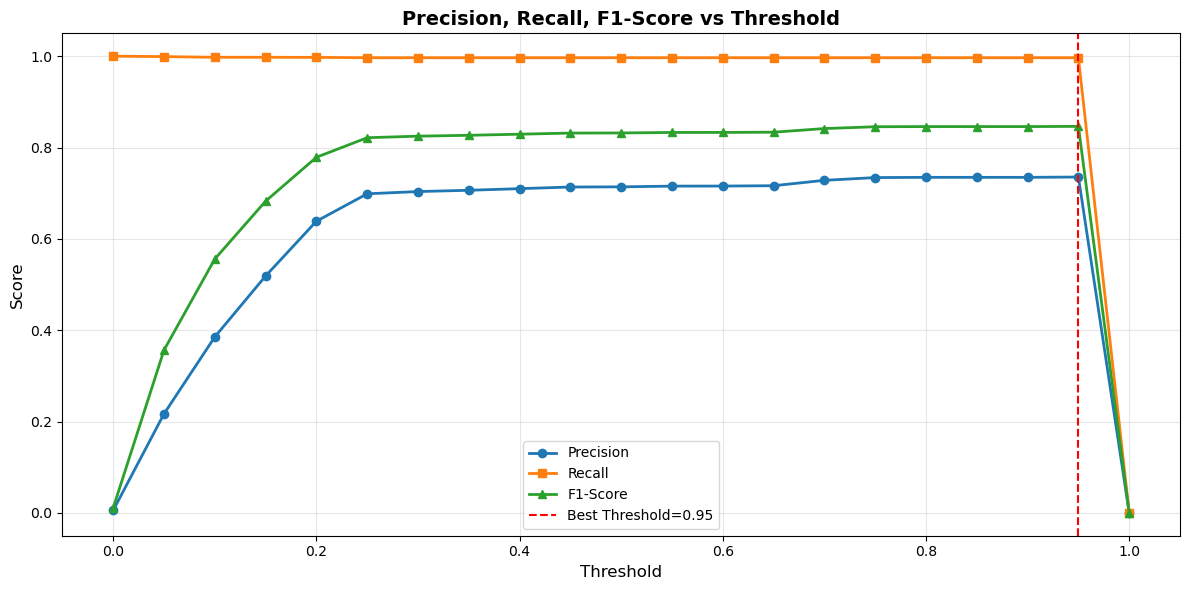

In [10]:
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.05)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    if y_pred_t.sum() == 0:
        precisions.append(0)
        recalls.append(0)
        f1s.append(0)
    else:
        precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
        recalls.append(recall_score(y_test, y_pred_t, zero_division=0))
        f1s.append(f1_score(y_test, y_pred_t, zero_division=0))

plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', marker='s', linewidth=2)
plt.plot(thresholds, f1s, label='F1-Score', marker='^', linewidth=2)
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold={best_threshold:.2f}')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision, Recall, F1-Score vs Threshold', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Confusion Matrix với ngưỡng tối ưu

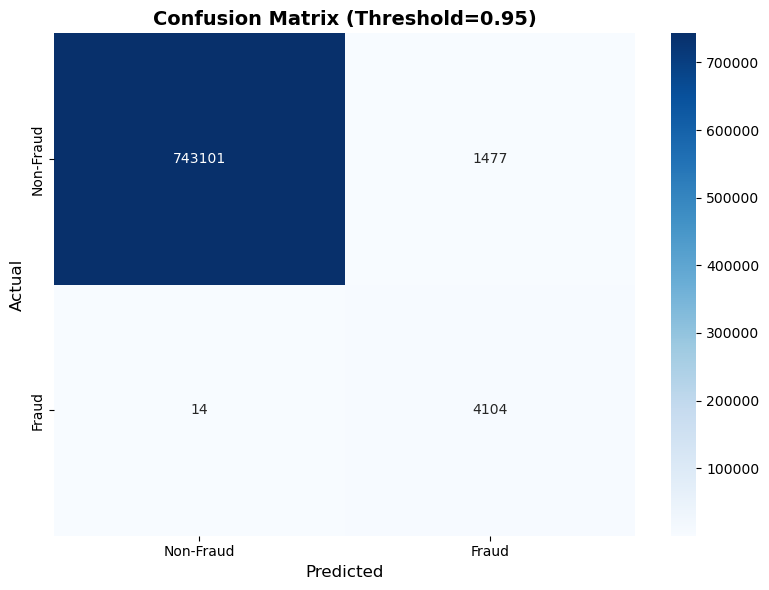


Classification Report với threshold=0.95:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    744578
           1       0.74      1.00      0.85      4118

    accuracy                           1.00    748696
   macro avg       0.87      1.00      0.92    748696
weighted avg       1.00      1.00      1.00    748696



In [11]:
import seaborn as sns

y_pred_best = (y_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title(f'Confusion Matrix (Threshold={best_threshold:.2f})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nClassification Report với threshold={best_threshold:.2f}:")
print("="*80)
print(classification_report(y_test, y_pred_best))

## 10. Feature Importance

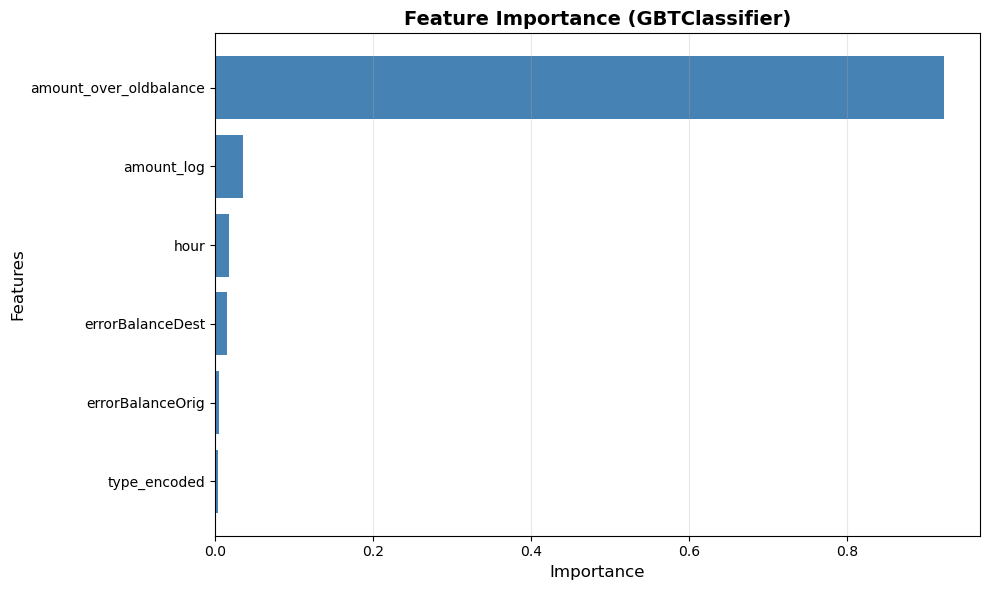


Feature Importance:
               Feature  Importance
amount_over_oldbalance    0.922478
            amount_log    0.035638
                  hour    0.017655
      errorBalanceDest    0.015188
      errorBalanceOrig    0.004683
          type_encoded    0.004357


In [12]:
# Lấy feature importance
import pandas as pd

feature_importance = model.featureImportances.toArray()

importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=True)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance (GBTClassifier)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print("="*80)
print(importance_df.sort_values('Importance', ascending=False).to_string(index=False))

## 11. Tóm tắt kết quả

In [13]:
print("="*80)
print("TÓM TẮT KẾT QUẢ TRAINING")
print("="*80)
print(f"\n📊 Dataset:")
print(f"   - Train size: {train_scaled.count():,} samples")
print(f"   - Test size: {test_scaled.count():,} samples")
print(f"   - Features: {len(feature_cols)}")
print(f"   - Fraud/Non-fraud ratio: 1:{weight_ratio:.0f}")

print(f"\n🎯 Model Performance:")
print(f"   - Model: GBTClassifier (Spark MLlib)")
print(f"   - ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"   - PR-AUC: {average_precision_score(y_test, y_proba):.4f}")
print(f"   - Best Threshold: {best_threshold:.2f}")
print(f"   - Best F1-Score: {best_f1:.4f}")

y_pred_final = (y_proba >= best_threshold).astype(int)
from sklearn.metrics import precision_score, recall_score
precision_final = precision_score(y_test, y_pred_final)
recall_final = recall_score(y_test, y_pred_final)

print(f"   - Precision: {precision_final:.4f}")
print(f"   - Recall: {recall_final:.4f}")

print(f"\n💾 Saved Files:")
print(f"   - gbt_fraud_model/ (Spark GBT model)")
print(f"   - spark_scaler_model/ (Spark StandardScaler)")

print(f"\n✅ Training hoàn thành!")
print("="*80)

# Dừng Spark Session
spark.stop()
print("\n🛑 Đã dừng Spark Session")

TÓM TẮT KẾT QUẢ TRAINING

📊 Dataset:
   - Train size: 1,744,580 samples
   - Test size: 748,696 samples
   - Features: 6
   - Fraud/Non-fraud ratio: 1:531

🎯 Model Performance:
   - Model: GBTClassifier (Spark MLlib)
   - ROC-AUC: 0.9996
   - PR-AUC: 0.9663
   - Best Threshold: 0.95
   - Best F1-Score: 0.8463
   - Precision: 0.7354
   - Recall: 0.9966

💾 Saved Files:
   - gbt_fraud_model/ (Spark GBT model)
   - spark_scaler_model/ (Spark StandardScaler)

✅ Training hoàn thành!

🛑 Đã dừng Spark Session
